<a href="https://colab.research.google.com/github/Eric881028/-/blob/%E5%B7%A8%E9%87%8F%E8%B3%87%E6%96%99%E4%BD%9C%E6%A5%AD/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#安裝套件用於抓取google drive圖片
!mkdir -p cat_dog_train
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
url='https://drive.google.com/uc?id=1NYAsskGbvXpuoj5i-pHlGXhoVyXgQV0J'
output='cat_dog_train/PetImages.zip'

import gdown
gdown.download(url=url,output=output,quiet=False,fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1NYAsskGbvXpuoj5i-pHlGXhoVyXgQV0J
From (redirected): https://drive.google.com/uc?id=1NYAsskGbvXpuoj5i-pHlGXhoVyXgQV0J&confirm=t&uuid=4d8679a8-563d-49af-b7df-569d9e135db7
To: /content/cat_dog_train/PetImages.zip
100%|██████████| 723M/723M [00:07<00:00, 90.7MB/s]


'cat_dog_train/PetImages.zip'

In [3]:
!unzip cat_dog_train/PetImages.zip -d cat_dog_train

串流輸出內容已截斷至最後 5000 行。
  inflating: cat_dog_train/PetImages/Dog/5164.jpg  
  inflating: cat_dog_train/PetImages/Dog/5165.jpg  
  inflating: cat_dog_train/PetImages/Dog/5166.jpg  
  inflating: cat_dog_train/PetImages/Dog/5167.jpg  
  inflating: cat_dog_train/PetImages/Dog/5168.jpg  
  inflating: cat_dog_train/PetImages/Dog/5169.jpg  
  inflating: cat_dog_train/PetImages/Dog/517.jpg  
  inflating: cat_dog_train/PetImages/Dog/5170.jpg  
  inflating: cat_dog_train/PetImages/Dog/5171.jpg  
  inflating: cat_dog_train/PetImages/Dog/5172.jpg  
  inflating: cat_dog_train/PetImages/Dog/5173.jpg  
  inflating: cat_dog_train/PetImages/Dog/5174.jpg  
  inflating: cat_dog_train/PetImages/Dog/5177.jpg  
  inflating: cat_dog_train/PetImages/Dog/5178.jpg  
  inflating: cat_dog_train/PetImages/Dog/5179.jpg  
  inflating: cat_dog_train/PetImages/Dog/518.jpg  
  inflating: cat_dog_train/PetImages/Dog/5180.jpg  
  inflating: cat_dog_train/PetImages/Dog/5181.jpg  
  inflating: cat_dog_train/PetImages/Dog/5182

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
#處理圖片資料集

image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_dog_train/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    labels='inferred', 
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_dog_train/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    labels='inferred', 
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [6]:
#get the class name 
print("class name:",train_ds.class_names)

class name: ['Cat', 'Dog']


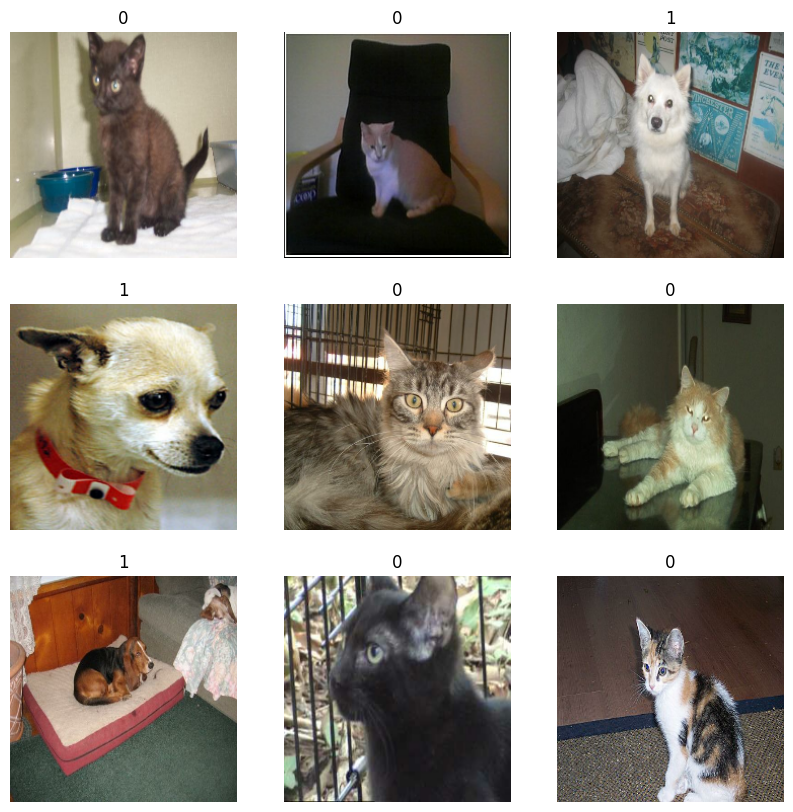

In [7]:
#print cat and dog image

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
#a batch_size of images (batch_size=32)
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
#data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
    ]
)

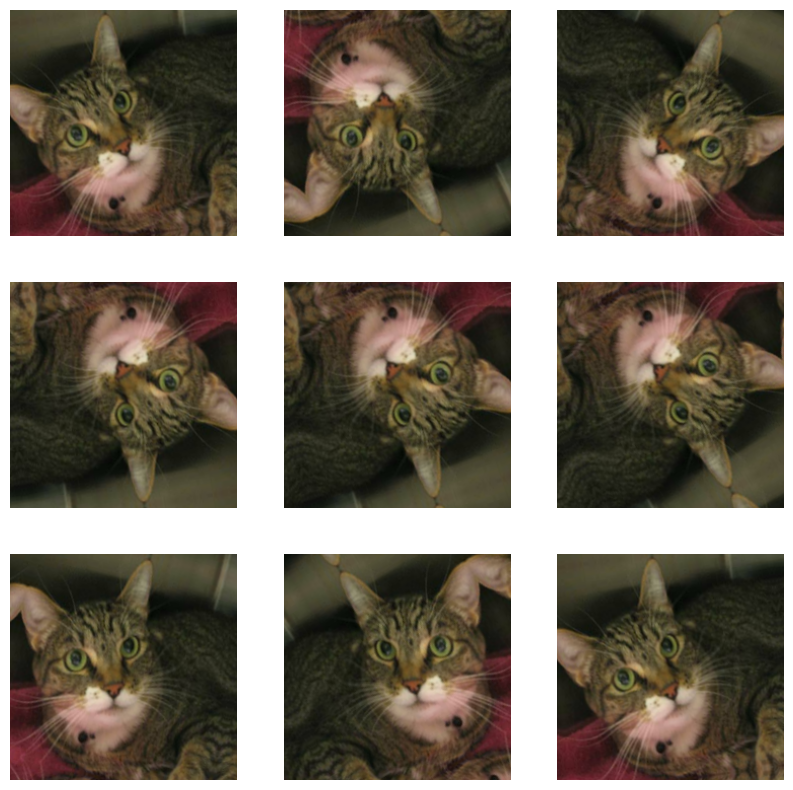

In [9]:
#data_augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [10]:
#取得MobileNetV2網路架構
#include_top為False，表示只取得卷積層部分，不取得classifier部分，也就是FC層

IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

print("我們採用MobileNetV2網路架構，參數為imagenet，改造前的網路層數為: ", len(base_model.layers))

9406464/9406464 [==============================] - 0s 0us/step
我們採用MobileNetV2網路架構，參數為imagenet，改造前的網路層數為:  154


In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
#找出倒數第6層的資訊
base_model.layers[-6].output

<KerasTensor: shape=(None, 7, 7, 960) dtype=float32 (created by layer 'block_16_depthwise_relu')>

In [13]:
#layer名稱為: block_16_depthwise_relu之後的layer都將被刪除
#進行更換步驟，取出此層block_16_depthwise_relu的輸出
x=base_model.layers[-6].output

#將該層的輸出為一維陣列
i=layers.Flatten()(x)

#增加一層Dense，並把一維陣列作為輸入
#for 0/1 binary, set units=1 and use sigmoid 
output=layers.Dense(units=1,activation='sigmoid')(i)


In [14]:
#建立一個Model，將原本的MobileNetV2與剛剛做的輸出層一起放進來
model=keras.Model(inputs=base_model.input,outputs=output)

In [15]:
#先將此模型都不鎖定模型訓練，等等再調整
model.trainable = True

#total layers from MobileNetV2
print("我們採用MobileNetV2網路架構，參數為imagenet，經過改造後的網路層數為: ", len(model.layers))

#開始fine tune的layer層，可以自行設定
fine_tune_at = 100

#在fine_tune_at之前的layer層，都鎖定，不進行模型訓練
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

print("我們由第",fine_tune_at,"之後開始進行模型訓練，訓練的變數總共有",len(model.trainable_variables))

我們採用MobileNetV2網路架構，參數為imagenet，經過改造後的網路層數為:  151
我們由第 100 之後開始進行模型訓練，訓練的變數總共有 50


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [17]:
#學習率
rate = 0.0001

#編譯模型
#因為我們的圖片資料集為貓與狗，屬於二元推論，採用BinaryCrossentropy

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
#擬合

model.fit(x=train_ds,validation_data=val_ds, epochs=10, verbose=2)                      

Epoch 1/10
586/586 - 65s - loss: 0.4212 - accuracy: 0.8032 - val_loss: 0.4083 - val_accuracy: 0.8081 - 65s/epoch - 111ms/step
Epoch 2/10
586/586 - 41s - loss: 0.1980 - accuracy: 0.9165 - val_loss: 0.3393 - val_accuracy: 0.8499 - 41s/epoch - 70ms/step
Epoch 3/10
586/586 - 41s - loss: 0.0910 - accuracy: 0.9667 - val_loss: 0.4281 - val_accuracy: 0.8469 - 41s/epoch - 69ms/step
Epoch 4/10
586/586 - 41s - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.4654 - val_accuracy: 0.8623 - 41s/epoch - 71ms/step
Epoch 5/10
586/586 - 42s - loss: 0.0352 - accuracy: 0.9878 - val_loss: 0.4155 - val_accuracy: 0.8864 - 42s/epoch - 71ms/step
Epoch 6/10
586/586 - 44s - loss: 0.0262 - accuracy: 0.9907 - val_loss: 0.4618 - val_accuracy: 0.8847 - 44s/epoch - 75ms/step
Epoch 7/10
586/586 - 43s - loss: 0.0228 - accuracy: 0.9921 - val_loss: 0.5911 - val_accuracy: 0.8789 - 43s/epoch - 73ms/step
Epoch 8/10
586/586 - 43s - loss: 0.0240 - accuracy: 0.9910 - val_loss: 1.2772 - val_accuracy: 0.7780 - 43s/epoch - 74ms/step

In [19]:
#作業
#透過已經完成的fine tune模型進行貓狗照片推論，請自行上網抓取照片進行推論

In [20]:
#下載圖片至VM端
url='https://drive.google.com/file/d/18B4SbLSYbmafd5hfAgId_FfO-estgAa8/view?usp=share_link'
output='cat_dog_train/cat_dog.zip'
import gdown
gdown.download(url=url,output=output,quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=18B4SbLSYbmafd5hfAgId_FfO-estgAa8
To: /content/cat_dog_train/cat_dog.zip
100%|██████████| 942k/942k [00:00<00:00, 134MB/s]


'cat_dog_train/cat_dog.zip'

In [21]:
#解壓縮圖片檔，會產生兩個目錄分別是 Cat 與 Dogn
!unzip cat_dog_train/cat_dog.zip -d cat_dog_train

Archive:  cat_dog_train/cat_dog.zip
   creating: cat_dog_train/cat_dog/cat/
  inflating: cat_dog_train/cat_dog/cat/cat (1).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (10).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (11).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (12).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (13).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (14).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (15).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (16).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (17).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (18).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (19).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (2).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (20).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (21).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (22).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (23).jpg  
  inflating: cat_dog_train/cat_dog/cat/cat (24).jpg  
  inflat

In [22]:
# 載入推論圖片資料集
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_dog_train/cat_dog",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
)

# 進行推論
predictions = model.predict(inference_ds)

Found 58 files belonging to 2 classes.
2/2 [==============================] - 1s 561ms/step


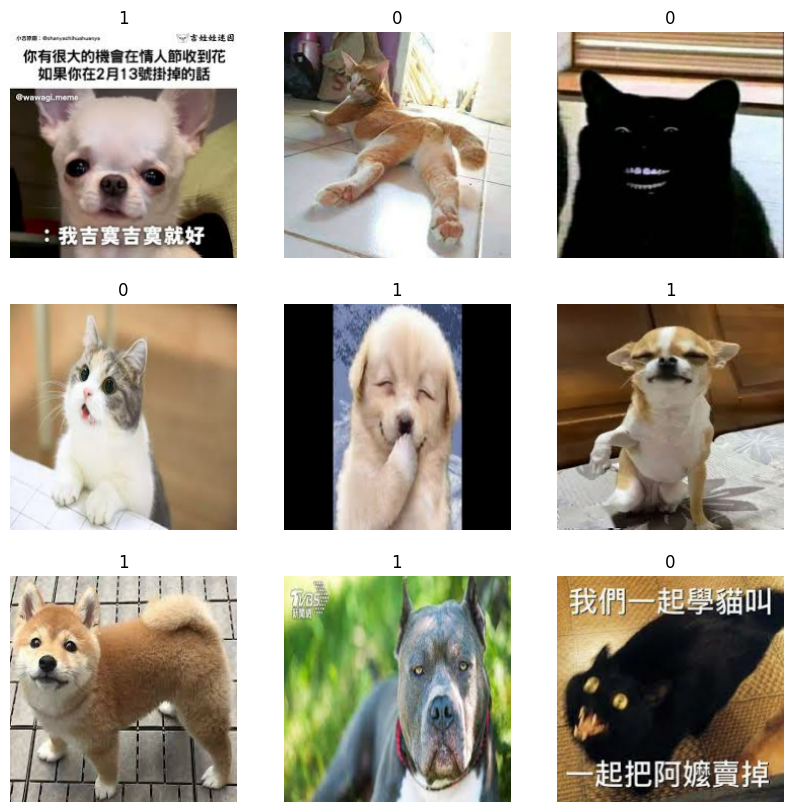

In [23]:
plt.figure(figsize=(10, 10))
#a batch_size of images (batch_size=32)
for images, labels in inference_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")